In [241]:
import pennylane as qml
from pennylane import numpy as np

In [242]:

num_qubits = 4 
dev = qml.device('default.qubit', wires=num_qubits)

In [243]:
"""
import numpy as np
import matplotlib.pyplot as plt

# sample data
np.random.seed(3)  
data_x = np.random.rand(300, 2)   #features
data_y = np.random.randint(0, 2, 300)  #binary labels

# Plotting the data
plt.figure(figsize=(8, 6))
plt.scatter(data_x[data_y == 0][:, 0], data_x[data_y == 0][:, 1], color='red', label='Class 0')
plt.scatter(data_x[data_y == 1][:, 0], data_x[data_y == 1][:, 1], color='blue', label='Class 1')
plt.title('Sample Data Plot')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()
"""


"\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# sample data\nnp.random.seed(3)  \ndata_x = np.random.rand(300, 2)   #features\ndata_y = np.random.randint(0, 2, 300)  #binary labels\n\n# Plotting the data\nplt.figure(figsize=(8, 6))\nplt.scatter(data_x[data_y == 0][:, 0], data_x[data_y == 0][:, 1], color='red', label='Class 0')\nplt.scatter(data_x[data_y == 1][:, 0], data_x[data_y == 1][:, 1], color='blue', label='Class 1')\nplt.title('Sample Data Plot')\nplt.xlabel('Feature 1')\nplt.ylabel('Feature 2')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

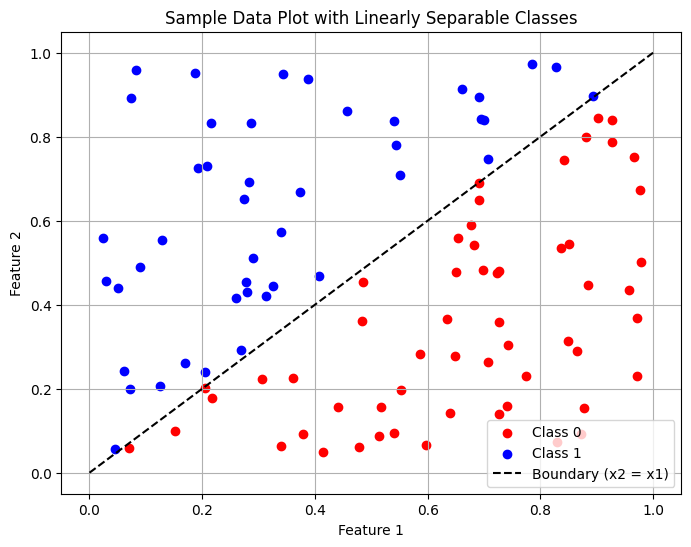

In [244]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(3)

# Generate random features
data_x = np.random.rand(100, 2)  # 300 samples, 2 features

# Assign labels based on a linear separator
# Example: label 1 if feature2 > feature1 (i.e., above the line x2 = x1), else label 0
data_y = (data_x[:, 1] > data_x[:, 0]).astype(int)

# Plotting the data
plt.figure(figsize=(8, 6))
plt.scatter(data_x[data_y == 0][:, 0], data_x[data_y == 0][:, 1], color='red', label='Class 0')
plt.scatter(data_x[data_y == 1][:, 0], data_x[data_y == 1][:, 1], color='blue', label='Class 1')

# Draw the line x2 = x1 to show the boundary
plt.plot([0, 1], [0, 1], 'k--', label='Boundary (x2 = x1)')

plt.title('Sample Data Plot with Linearly Separable Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


In [245]:
def batch_data(data_x, data_y, batch_size):
    """
    Generator function to yield batches of data.
    
    Parameters:
    - data_x: NumPy array of input features, shape (total_samples, features)
    - data_y: NumPy array of labels, shape (total_samples,)
    - batch_size: integer, size of each batch
    
    Yields:
    - batch_x: NumPy array of features for the batch
    - batch_y: NumPy array of labels for the batch
    """
    total_samples = data_x.shape[0]
    indices = np.arange(total_samples)
    np.random.shuffle(indices)  # Shuffle the data
    
    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        batch_indices = indices[start_idx:end_idx]
        batch_x = data_x[batch_indices]
        batch_y = data_y[batch_indices]
        yield (batch_x, batch_y)

# Example usage:
# for batch_x, batch_y in batch_data(data_x, data_y, 10):
#     print(batch_x, batch_y)

In [246]:
def homogeneous_batch_data(data_x, data_y, batch_size):
    """
    Generator function to yield batches of data where all samples in a batch have the same label.
    
    Parameters:
    - data_x: NumPy array of input features, shape (total_samples, features)
    - data_y: NumPy array of labels, shape (total_samples,)
    - batch_size: integer, size of each batch
    
    Yields:
    - batch_x: NumPy array of features for the batch
    - batch_y: NumPy array of labels for the batch
    """
    # Segregate data by labels
    unique_labels = np.unique(data_y)
    for label in unique_labels:
        # Extract all samples with the current label
        label_indices = np.where(data_y == label)[0]
        np.random.shuffle(label_indices)  # Shuffle indices to randomize batch content
        
        for start_idx in range(0, len(label_indices), batch_size):
            end_idx = min(start_idx + batch_size, len(label_indices))
            batch_indices = label_indices[start_idx:end_idx]
            batch_x = data_x[batch_indices]
            batch_y = data_y[batch_indices]
            yield (batch_x, batch_y)

# Example usage:
# data_x, data_y are your datasets
# for batch_x, batch_y in homogeneous_batch_data(data_x, data_y, 4):
#     print("Batch X:", batch_x)
#     print("Batch Y:", batch_y)

# res = homogeneous_batch_data(data_x, data_y, 4)
# # batch_x, batch_y= homogeneous_batch_data(data_x, data_y, 4)
# batch_x, batch_y = next(res)
# print(batch_x)
# print(batch_y)
# for i in range(300):
#     batch_x, batch_y = next(res)
#     print(batch_x)
#     print(batch_y)

In [247]:
def func_phi(w1,w2):
    return (w1-w2)**2

In [248]:
def ansatz(params):
    qml.RY(params[0],wires=[0])
    qml.RY(params[1],wires=[1])
    qml.CZ(wires=[0,1])

In [249]:
# Data Embedding for batch size = 4
def data_embedding_batch4(batch_x):
    for i in range(len(batch_x)):
        x = batch_x[i]
        phi = func_phi(x[0],x[1])
        qml.ctrl(qml.RY,control=[2,3],control_values=[1,1])(phi,[0])
        qml.ctrl(qml.RY,control=[2,3],control_values=[1,1])(phi,[1])
        if(i==0):
            qml.PauliX(wires=[3])
        elif(i==1):
            qml.PauliX(wires=[2])
            qml.PauliX(wires=[3])
        elif(i==2):
            qml.PauliX(3)
    # qml.Barrier(only_visual=True)
    qml.PauliX(wires=[2])
    qml.PauliX(wires=[3])
   
        


In [250]:
def buildGroverOracleAndDiffuser(params,data):
    data_embedding_batch4(data)
    # qml.Barrier(only_visual=True)
    ansatz(params)
    qml.CCZ(wires=[0,2,3])
    qml.templates.GroverOperator(wires=[2,3])

In [251]:
batch_generator = homogeneous_batch_data(data_x, data_y, 4)
batch_x, batch_y = next(batch_generator)

numberOfGroverIteration = 2

@qml.qnode(dev)
def quantum_circuit(params, data):
    hadmadard_range = range(2,4)
    for i in hadmadard_range:
        qml.Hadamard(wires=i)
    for i in range(numberOfGroverIteration):
        qml.Barrier(only_visual=True)
        buildGroverOracleAndDiffuser(params,data)
    return qml.probs(wires=[0,1,2,3])

print(qml.draw(quantum_circuit)([0.1,0.2],batch_x))




# optimizer = qml.GradientDescentOptimizer(stepsize=0.1)


# def cost(params, data, target):
#     predictions = quantum_circuit(params, data)
#     return ((predictions - target)**2).mean()


# params = np.random.random([num_qubits])
# data = np.random.random([len(params)])  
# target = np.array([1, -1]) 

# for it in range(100):  # The number of iterations of optimization
#     params, prev_cost = optimizer.step_and_cost(lambda v: cost(v, data, target), params)
#     print(f'Iteration {it+1}: cost = {prev_cost}')


0: ─────||─╭RY(0.13)──────────────╭RY(0.02)──────────────╭RY(0.14)──────────────╭RY(0.14)──RY(0.10)
1: ─────||─│─────────╭RY(0.13)────│─────────╭RY(0.02)────│─────────╭RY(0.14)────│─────────╭RY(0.14)
2: ──H──||─├●────────├●───────────├●────────├●─────────X─├●────────├●───────────├●────────├●───────
3: ──H──||─╰●────────╰●─────────X─╰●────────╰●─────────X─╰●────────╰●─────────X─╰●────────╰●───────

────────────╭●─╭●──────────────────||─╭RY(0.13)──────────────╭RY(0.02)──────────────╭RY(0.14)
───RY(0.20)─╰Z─│───────────────────||─│─────────╭RY(0.13)────│─────────╭RY(0.02)────│────────
───X───────────├●─╭GroverOperator──||─├●────────├●───────────├●────────├●─────────X─├●───────
───X───────────╰Z─╰GroverOperator──||─╰●────────╰●─────────X─╰●────────╰●─────────X─╰●───────

───────────────╭RY(0.14)──RY(0.10)───────────╭●─╭●─────────────────┤ ╭Probs
──╭RY(0.14)────│─────────╭RY(0.14)──RY(0.20)─╰Z─│──────────────────┤ ├Probs
──├●───────────├●────────├●─────────X───────────├●─╭GroverOperator─┤ ├